## Import Python libraries

In [1]:
import pickle
from pathlib import Path
from skimage import io

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# import keras library
import keras

# import Sequential from the keras models module
from keras import Sequential 

# import Dense, Dropout, Flatten, Conv2D, MaxPooling2D from the keras layers module
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

## Load image labels

In [2]:
# load labels.csv from datasets folder using pandas
labels = pd.read_csv('labels.csv', index_col=0)

# print value counts for genus
print(labels.genus.value_counts())

# assign the genus label values to y
y = labels.genus.values

1.0    827
0.0    827
Name: genus, dtype: int64


## Examine RGB values in an image matrix

Example image has shape:  (50, 50, 3)
RGB values for the top left pixel are: [127 108  95]


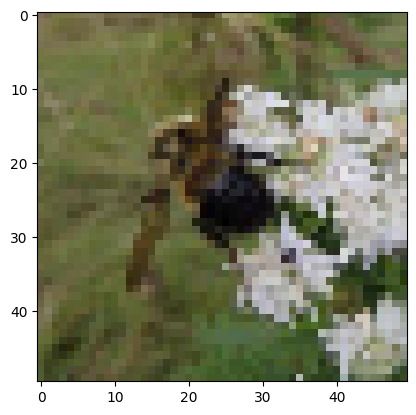

In [3]:
# load an image and explore
example_image = io.imread('images/{}.jpg'.format(labels.index[0]))

# show image
plt.imshow(example_image)

# print shape
print('Example image has shape: ', example_image.shape)
                    
# print color channel values for top left pixel
print('RGB values for the top left pixel are:', example_image[0, 0, :])

## Importing the image data

In [4]:
# create empty list
image_list = []

for i in labels.index:
    # load image
    img = io.imread('images/{}.jpg'.format(i)).astype(np.float64)
        
    # append to list of all images
    image_list.append(img)
    
# convert image list to single array
X = np.array(image_list)

print(X.shape)

(1654, 50, 50, 3)


## Split into train, test, and evaluation sets

In [5]:
# split out evaluation sets (x_eval and y_eval)
x_interim, x_eval, y_interim, y_eval = train_test_split(X,
                                           y,
                                           test_size=0.2,
                                           random_state=52)

# split remaining data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x_interim, y_interim, test_size=0.4, random_state = 52)

# examine number of samples in train, test, and validation sets
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_eval.shape[0], 'eval samples')

x_train shape: (793, 50, 50, 3)
793 train samples
530 test samples
331 eval samples


##  Normalize image data

In [6]:
# initialize standard scaler
ss = StandardScaler()

def scale_features(train_features, test_features):
    for image in train_features:
        # for each channel, apply standard scaler's fit_transform method
        for channel in range(image.shape[2]):
            image[:, :, channel] = ss.fit_transform(image[:, :, channel])
    for image in test_features:
        # for each channel, apply standard scaler's transform method
        for channel in range(image.shape[2]):
            image[:, :, channel] = ss.transform(image[:, :, channel])

# apply scale_features to four sets of features
scale_features(x_interim, x_eval)
scale_features(x_train, x_test)

## Model building 

In [7]:
# set model constants
num_classes = 1
# define model as Sequential
model = Sequential()
# first convolutional layer with 32 filters
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(50, 50, 3)))
# add a second 2D convolutional layer with 64 filters
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
# reduce dimensionality through max pooling
model.add(MaxPooling2D(pool_size=(2,2)))
# third convolutional layer with 64 filters
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
# add dropout to prevent over fitting
model.add(Dropout(0.25))
# necessary flatten step preceeding dense layer
model.add(Flatten())
# fully connected layer
model.add(Dense(128, activation='relu'))
# add additional dropout to prevent overfitting
model.add(Dropout(0.5))
# prediction layers
model.add(Dense(num_classes, activation='sigmoid', name='preds'))
# show model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 64)        36928     
                                                                 
 dropout (Dropout)           (None, 21, 21, 64)        0         
                                                                 
 flatten (Flatten)           (None, 28224)             0         
                                                        

## Compile and train model

In [8]:
model.compile(
    # set the loss as binary_crossentropy
    loss='binary_crossentropy',
    # set the optimizer as stochastic gradient descent
    optimizer=keras.optimizers.SGD(lr=0.001),
    # set the metric as accuracy
    metrics=['accuracy']
)

# mock-train the model using the first ten observations of the train and test sets
model.fit(
    x_train[:10, :, :, :],
    y_train[:10],
    epochs=5,
    verbose=1,
    validation_data=(x_test[:10, :, :, :], y_test[:10])
)

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/5
1/1 [==============================] - 3s 3s/step - loss: 0.7317 - accuracy: 0.5000 - val_loss: 0.6767 - val_accuracy: 0.4000
Epoch 2/5
1/1 [==============================] - 0s 418ms/step - loss: 0.6314 - accuracy: 0.7000 - val_loss: 0.6736 - val_accuracy: 0.6000
Epoch 3/5
1/1 [==============================] - 1s 565ms/step - loss: 0.8150 - accuracy: 0.5000 - val_loss: 0.6737 - val_accuracy: 0.7000
Epoch 4/5
1/1 [==============================] - 0s 460ms/step - loss: 0.6560 - accuracy: 0.7000 - val_loss: 0.6754 - val_accuracy: 0.7000
Epoch 5/5
1/1 [==============================] - 0s 354ms/step - loss: 0.7330 - accuracy: 0.4000 - val_loss: 0.6760 - val_accuracy: 0.6000


## Load pre-trained model and score

In [10]:
# load pre-trained model
pretrained_cnn = keras.models.load_model('pretrained_model.h5')

# evaluate model on test set
score = pretrained_cnn.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

print("")

# evaluate model on holdout set
eval_score = pretrained_cnn.evaluate(x_eval, y_eval)
# print loss score
print('Eval loss:', eval_score[0])
# print accuracy score
print('Eval accuracy:', eval_score[1])

Test loss: 0.6719561815261841
Test accuracy: 0.6188679337501526

11/11 [==============================] - 2s 189ms/step - loss: 0.6702 - accuracy: 0.6375
Eval loss: 0.6701620221138
Eval accuracy: 0.6374622583389282


## Visualize model training history


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


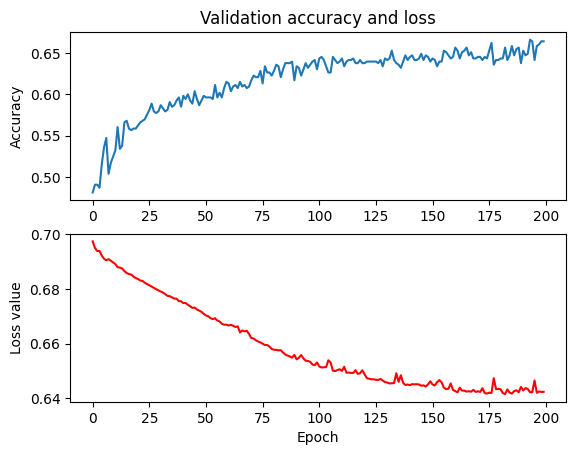

In [11]:
# load history
with open('model_history.pkl', 'rb') as f:
    pretrained_cnn_history = pickle.load(f)

# print keys for pretrained_cnn_history dict
print(pretrained_cnn_history.keys())

fig = plt.figure(1)
plt.subplot(211)
# plot the validation accuracy
plt.plot(pretrained_cnn_history['val_acc'])
plt.title('Validation accuracy and loss')
plt.ylabel('Accuracy')
plt.subplot(212)
# plot the validation loss
plt.plot(pretrained_cnn_history['val_loss'], 'r')
plt.xlabel('Epoch')
plt.ylabel('Loss value');

## Generate predictions

In [12]:
# predicted probabilities for x_eval
y_proba = pretrained_cnn.predict(x_eval)

print("First five probabilities:")
print(y_proba[:5])
print("")

# predicted classes for x_eval
y_pred = np.round(y_proba).astype('int')

print("First five class predictions:")
print(y_pred[:5])
print("")

11/11 [==============================] - 2s 151ms/step
First five probabilities:
[[0.51043946]
 [0.55088645]
 [0.63334477]
 [0.1811149 ]
 [0.3395768 ]]

First five class predictions:
[[1]
 [1]
 [1]
 [0]
 [0]]

